# Ayuda slides

In [1]:
print '''Copy the next code into a first Raw NBconvert Cell to avoid display the commands
<style type="text/css">
.input, .output_prompt {
display:none !important;
}
</style>
'''

Copy the next code into a first Raw NBconvert Cell to avoid display the commands
<style type="text/css">
.input, .output_prompt {
display:none !important;
}
</style>



b to hide presentation
Links:
* http://stackoverflow.com/questions/20441848/how-do-i-separate-slides-when-exporting-an-ipython-notebook-to-reveal-js    
* http://www.slideviper.oquanta.info/tutorial/slideshow_tutorial_slides.html#/7  
* https://seqqc.wordpress.com/2015/02/22/make-slides-with-ipython-notebook/
* http://hannes-brt.github.io/blog/2013/08/11/ipython-slideshows-will-change-the-way-you-work/

The following commands gives the separation of slides and arrows:

In [1]:
%%bash
ipython nbconvert Indicadores-articulos.ipynb --to slides --reveal-prefix "http://cdn.jsdelivr.net/reveal.js/2.6.2" && cp Indicadores-articulos.slides.html /var/www/downloads
git commit -am "Slides update"
git push origin master

[master 0fd6037] Slides update
 3 files changed, 5477 insertions(+), 15714 deletions(-)
 rewrite pandas/Indicadores-articulos.ipynb (90%)


[NbConvertApp] Using existing profile dir: u'/home/restrepo/.ipython/profile_default'
[NbConvertApp] Converting notebook Indicadores-articulos.ipynb to slides
[NbConvertApp] Support files will be in Indicadores-articulos_files/
[NbConvertApp] Loaded template slides_reveal.tpl
[NbConvertApp] Writing 422306 bytes to Indicadores-articulos.slides.html
remote: This repository moved. Please use the new location:        
remote:   https://github.com/restrepo/gssis.git        
To git@github.com:rescolo/gssis.git
   699712e..0fd6037  master -> master


The resulting slides are here:

http://gfif.udea.edu.co/downloads/Indicadores-articulos.slides.html#/

or

http://htmlpreview.github.io/?https://github.com/restrepo/gssis/blob/master/pandas/Indicadores-articulos.slides.html#/

<h1>Indicadores Instituto de Física</h1>
<h3>Diego Restrepo</h3>

http://stackoverflow.com/a/17231361

<h2 id="Articulos">Artículos</h2>
###Metodologia
Desde el perfil de [Google Scholar](https://scholar.google.com/citations?sortby=pubdate&hl=en&user=mxSOjTYAAAAJ&view_op=list_works) para el Instituto, se exportan todos los artículos en formato cvs.

Con el programa `cvsreader_udea.py` en la carpeta `utilities` del repositorio  de GitHub [`gssis`](https://github.com/restrepo/gssis) se añade la siguiente información:  

* El [DOI](http://search.crossref.org), usando el título y el apellido del primer autor de la publicación

* Con del DOI se pueden verificar todos los metadatos. En partcular el nombre exacto de la revista. [Ejemplo](http://api.crossref.org/works/10.1103/PhysRevD.93.015012) 

* Con el nombre exacto de la revista se obtiene la clasificación de Colciencias y su ISSN asociado desde la versión en [google spreadsheet](https://docs.google.com/spreadsheets/d/1umgapW8KOIPqmu_hyjon3n2SXbnbDlmnRnXzjUHcXHE/edit?usp=drive_web) del arhivo en excel del Publindex de Colciencias para revistas homologadas. (Se carga el csv desde el código)

* Con el ISSN se obtiene el factor de impacto con: [búsqueda de Google](https://goo.gl/JMHmhS)

Citaciones...

Finalmente el program extrae el primer autor de la UdeA de la lista de autores y le asocia el Grupo de Investigación correspondiente.

El resultado final esta en el [repositorio de GitHub](https://github.com/restrepo/gssis/blob/master/utilities/newcitations.csv)

##  Análisis de datos

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import numpy as np
import datetime
import re

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth',500)
def read_google_cvs(gss_url="http://spreadsheets.google.com",\
    gss_format="csv",\
    gss_key="0AuLa_xuSIEvxdERYSGVQWDBTX1NCN19QMXVpb0lhWXc",\
    gss_sheet=0,\
    gss_query="select B,D,E,F,I where (H contains 'GFIF') order by D desc",\
    gss_keep_default_na=False
    ):
    import urllib
    """
    read a google spreadsheet in cvs format and return a pandas DataFrame object.
       ....
       gss_keep_default_na: (False) Blank values are filled with NaN
    """
    issn_url="%s/tq?tqx=out:%s&tq=%s&key=%s&gid=%s" %(gss_url,\
                                           gss_format,\
                                           gss_query,\
                                           gss_key,\
                                           str(gss_sheet))

    gfile=urllib.urlopen(issn_url)
    return pd.read_csv(gfile,keep_default_na=gss_keep_default_na)

def plainstr(stra):
    return stra.replace('á','a').replace('é','e').replace('í','i').\
                replace('ó','o').replace('ú','u').replace('ñ','n')

In [4]:
df=pd.read_csv('https://raw.githubusercontent.com/restrepo/gssis/master/utilities/newcitations.csv')
df.columns

Index([u'Year', u'Type', u'Authors', u'Publication', u'Volume', u'Pages', u'ISSN', u'Title', u'Impreso', u'PDF', u'Group', u'DOI', u'Type II', u'Proyect ID', u'Institution Authors', u'Colciencias Clasification', u'Impact Factor', u'Proyecto', u'NPages'], dtype='object')

In [5]:
df.shape

(1011, 19)

In [6]:
df['Año']=df.Year
df['Tipo']=df.Type
df['Autor(es)']=df.Authors
df['Artículo']=df.Title
df['Vol.']=df.Volume
df['pág.']=df.Pages
df['Revista']=df.Publication
df['Grupo']=df.Group
df['Clasificación Colciencias']=df['Colciencias Clasification']
df['Factor de Impacto']=df['Impact Factor']

## Including citations...
To include in official code cvsreader_udea.py

In [7]:
pc=read_google_cvs(gss_key='1yQXdQdzsX9zBeui52bMcnN-JMt87ofHDjA58kwGJsdI',gss_query="select *")
df['Cites']=0
df['Simple']=df.Title.str.replace(r"[^a-zA-Z0-9 ]", " ").str.lower().str.replace('\s+','')
pc['Simple']=pc.Article.str.replace(r"[^a-zA-Z0-9 ]", " ").str.lower().str.replace('\s+','')
for i in range(df.shape[0]):
    mt=pc[pc.Simple.str.match(df.Simple[i])]
    if len(mt)>=1:
        rmt=mt
        if len(mt)>1:
            if len(mt[mt.Simple.str.contains(str(df.Volume[i]))])>0: #if 0 keep old match
                rmt=mt[mt.Simple.str.contains(str(df.Volume[i]))] #if >1 is a repeated entry
        
        df['Cites'][i]=rmt.Cites.replace('*','').replace('','0').astype(int).max()

Expected 12994 (Feb. 2016)

In [8]:
df.Cites.sum()

12657

### Filtramos las publicadas
Las que tienen ISSN o el DOI.

Se muestran algunos resultados...

In [9]:
publicadas=df[~np.logical_and(df['ISSN']=='0000-0000',df['DOI']=='Not DOI')]
publicadas=publicadas.reset_index(drop=True)
publicadas=publicadas.replace('','Desconocido')
publicadas['First_UdeA_Author']=publicadas['Institution Authors'].fillna('NN')\
.str.replace('Mora Ramos Miguel; ','').str.replace(';.*','')

#Ejemplo visualización
publicadas[['Año','Autor(es)','Artículo','Vol.','pág.','ISSN','Revista','Grupo','DOI','Clasificación Colciencias','Factor de Impacto','First_UdeA_Author']][publicadas['DOI']!='Not DOI'][-5:]

/usr/local/lib/python2.7/dist-packages/pandas/core/common.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


,Año,Autor(es),Artículo,Vol.,pág.,ISSN,Revista,Grupo,DOI,Clasificación Colciencias,Factor de Impacto,First_UdeA_Author
927,2016,"Arbeláez, Carolina; Longas, Robinson; Restrepo, Diego; Zapata, Oscar;",Fermion dark matter from SO (10) GUTs,93,13012,1550-7998,Physical Review D,GFIF: Grupo de Fenomenología de Interacciones Fundamentales,10.1103/physrevd.93.013012,A1,"4,691",Restrepo Quintero Diego Alejandro
928,2015,"Hollyhead, Katherine; Bastian, Nate; Adamo, Angela; Silva-Villa, Esteban; Dale, Jim; Ryon, JE; Gazak, Zack;","Studying the YMC population of M83: how long clusters remain embedded, their interaction with the ISM and implications for GC formation theories",449,1106,0035-8711,Monthly Notices of the Royal Astronomical Society,FACOM: Física y Astrofísica Computacional,10.1093/mnras/stv331,A1,"5,521",Silva Villa Esteban
929,2014,"Bastian, N; Adamo, Angela; Schirmer, M; Hollyhead, K; Beletsky, Y; Carraro, G; Davies, B; Gieles, M; Silva-Villa, E;",The effect of spatial resolution on optical and near-IR studies of stellar clusters: implications for the origin of the red excess,444,3829,0035-8711,Monthly Notices of the Royal Astronomical Society,FACOM: Física y Astrofísica Computacional,10.1093/mnras/stu1695,A1,"5,521",Silva Villa Esteban
930,2015,"Niederhofer, Florian; Hilker, Michael; Bastian, Nate; Silva-Villa, Esteban;",No evidence for significant age spreads in young massive LMC clusters,575,62,0000-0000,Astronomy & Astrophysics,FACOM: Física y Astrofísica Computacional,10.1051/0004-6361/201424455,00,"-1,0",Silva Villa Esteban
931,2014,"Ceballos, Jorge A; Giraldo, Marco A; Cossio, Pilar;",Effects of a disulfide bridge prior to amyloid formation of the ABRI peptide,4,36923,0000-0000,RSC Advances,Biofísica,10.1039/C4RA06034B,00,"-1,0",Giraldo Cadavid Marco A.


In [10]:
publicadas['Factor de Impacto']=publicadas['Factor de Impacto'].replace('Desconocido',-1)
publicadas['Factor de Impacto']=publicadas['Factor de Impacto'].str.replace(',','.').astype(float)
publicadas['Grupo']=publicadas['Grupo'].fillna('Unknown')

### Publicada últimos 5 años

In [11]:
publicadas5=publicadas[publicadas['Año']>datetime.datetime.now().year-5]

### Datos a analizar del TOTAL en Google Scholar:

In [12]:
dfp=pd.DataFrame()
dfp.append({'TOTAL':df.shape[0],'Publicadas':publicadas.shape[0],\
            'Publicadas últimos 5 años':publicadas5.shape[0]},ignore_index=True)

,Publicadas,Publicadas últimos 5 años,TOTAL
0,932,258,1011


### Preparando la tabla de datos

## Estudiantes

In [13]:
config_inf={'DEBUG':False} #Development mode
config_inf['Years']=range(1995,2016)

In [14]:
dfd=read_google_cvs(gss_key="0AuLa_xuSIEvxdERYSGVQWDBTX1NCN19QMXVpb0lhWXc",gss_query="select *",gss_sheet=2)
dfd['PROGRAMA']='Doctorado'
dfm=read_google_cvs(gss_key="0AuLa_xuSIEvxdERYSGVQWDBTX1NCN19QMXVpb0lhWXc",gss_query="select *",gss_sheet=1)
dfm['PROGRAMA']='Maestría'
dfe=dfd.append(dfm)
dfe.columns

Index([u'ASESOR', u'Becado de', u'CODIRECTOR', u'CORREO', u'Cédula', u'Distinción', u'Doble titulación', u'ESTANTE', u'ESTUDIANTE', u'Estado', u'Estado Laboral', u'Fecha de graduación', u'Fecha de ingreso', u'Fecha de sustentación', u'GRUPO', u'INSTITUTO', u'JURADO 1', u'JURADO 2', u'JURADO 3', u'Materias matriculas semestre 2011-1', u'NOMBRE TESIS', u'PROGRAMA', u'Pasantía', u'Proyecto ID', u'SIGNATURA', u'Situación', u'Unnamed: 0'], dtype='object')

In [15]:
dfe['Año de ingreso']=dfe['Fecha de ingreso'].replace('','0').replace('null','0').str.replace('-1','').str.replace('-2','').astype('int')
dfe['Año de graduación']=dfe['Fecha de graduación'].replace('','0').replace('null','0').str.replace('-1','').str.replace('-2','').astype('int')#.values
#dfe['Año de graduación'].values
dfei=dfe[dfe['Año de ingreso']>=config_inf['Years'][0]].reset_index(drop=True)
dfeg=dfe[dfe['Año de graduación']>=config_inf['Years'][0]].reset_index(drop=True)

### Estudiantes admitidos y matriculados

In [16]:
dfeit=dfei[np.logical_or(dfei['Estado']=='Activo',dfei['Estado']=='Graduado')]
dfeit[['Año de ingreso','Estado']]
dfei.groupby('Año de ingreso').count()['ASESOR'][::-1]

Año de ingreso
2016              12
2015               8
2014              28
2013              19
2012              14
2011              10
2010              12
2009               8
2008              15
2007               8
2006              18
2005              13
2004              11
2003               3
2002               5
2001               7
2000               2
1999               4
1998               6
1997               3
1995               2
Name: ASESOR, dtype: int64

### Artículos con participación de estudiantes

In [17]:
dfei=dfei[dfei.Estado!='Desertor'].reset_index(drop=True)
#Estudiantes
student_coauthor=1 #until 2 years after graduation date
dfd=pd.Series()
art_est=pd.Series()
dfd['D']=dfei[dfei.PROGRAMA=='Doctorado'].reset_index(drop=True)
dfd['M']=dfei[dfei.PROGRAMA=='Maestría'].reset_index(drop=True)
dfd['P']=dfei
for k in dfd.keys():
    art_est[k]=pd.DataFrame()
#phdest=pd.DataFrame()
    dfd[k]['Author']=''
    for i in range(dfd[k].shape[0]):
        est=re.sub('\s+$','',re.sub('^\s+','',dfd[k]['ESTUDIANTE'][i])).replace('  ',' ').split(' ')
        if len(est)==4:
            dfd[k]['Author'][i]='%s, %s' %(plainstr(est[2]),est[0][0])
        elif len(est)==3:        
            dfd[k]['Author'][i]='%s, %s' %(plainstr(est[1]),est[0][0])
        elif len(est)==2:
            dfd[k]['Author'][i]='%s, %s' %(plainstr(est[1]),est[0][0])
        else:
            dfd[k]['Author'][i]='%s, %s' %(plainstr(est[-1]),est[0][0])
        #special cases
        if dfd[k]['Author'][i]=='Duque, C':
            dfd[k]['Author'][i]='Duque, CM'
    
        ma=publicadas[publicadas['Autor(es)'].str.contains(dfd[k]['Author'][i])]
        if ma.shape[0]>0:
            ma['Estudiante']=dfd[k]['Author'][i]
            ma['Año Graduación']=dfd[k]['Fecha de graduación'][i]
            if dfd[k]['Fecha de graduación'][i]!='':
                ya=eval(re.sub('-[12]$','',dfd[k]['Fecha de graduación'][i]))+student_coauthor
                ma=ma[ma['Año']<=ya]
    
        art_est[k]=art_est[k].append(ma)
        #phdest=phdest.append({'ESTUDIANTE':dfd[k]['ESTUDIANTE'][i],'Autor':dfd['Author'][i],\
        #                        'Fecha de graduación':dfd[k]['Fecha de graduación'][i],\
        #                        'Artículos':ma.shape[0]},ignore_index=True)

    #Filter pandas dataframe
    #Fill from phd_students.xlsx (see below) to cross check the data
    art_est[k]=art_est[k].drop_duplicates().reset_index(True).sort('Año',ascending=False).reset_index(drop=True)
    art_est[k]=art_est[k][['Tipo','Artículo','Autor(es)','Año Graduación','Año','Revista','ISSN','Estudiante']]

In [18]:
autor=pd.Series()
autor['Posgrado']=art_est.P.groupby('Año').count().Tipo[::-1]
autor['Doctorado']  =art_est.D.groupby('Año').count().Tipo[::-1]
autor['Master']=art_est.M.groupby('Año').count().Tipo[::-1]

In [19]:
autor.Posgrado.astype(int)

Año
2016     1
2015    18
2014    17
2013    19
2012    20
2011    18
2010    24
2009    38
2008    36
2007    35
2006    47
2005    33
2004    27
2003    28
2002    17
2001    30
2000    13
1999     3
1998     1
1997     2
1996     4
1993     1
Name: Tipo, dtype: int64

In [20]:
t=publicadas['Año'].value_counts()
i=publicadas[publicadas.Tipo=='Internacional']['Año'].value_counts()
n=publicadas[publicadas.Tipo=='Nacional']['Año'].value_counts()
facom=publicadas[publicadas.Grupo.str.contains('FACOM')]['Año'].value_counts()

In [21]:
rdf=pd.DataFrame()
for y in range(1995,2016)[::-1]:
    year=False
    if y in t.keys():
        na=t[y]
    else: na=0
    if y in i.keys():
        ni=i[y]
    else: ni=0
    if y in n.keys():
        nn=n[y]
    else: nn=0
    if y in facom.keys():
        nfacom=facom[y]
    else: nfacom=0
    for k in ['Posgrado','Master','Doctorado']:
        if not y in autor[k]:
            autor[k][y]=0
    #FAudea=publicadas[publicadas['Año']==y]['Institution Authors'].fillna('NN')\
    #.str.replace('Mora Ramos Miguel; ','').str.replace(';.*','').unique().shape[0]
    FAudea=publicadas[publicadas['Año']==y]['First_UdeA_Author'].unique().shape[0]
    Audea=np.unique(publicadas[publicadas['Año']==y]['Institution Authors'].fillna('NN').str.split('; ').sum()).shape[0]
        
    rdf=rdf.append({'year':y,'articles':na,'isi_o_scopus':ni,'nacional':nn,'facom':nfacom,\
                   'first_UdeA_author':FAudea,'UdeA_author':Audea,\
                   'autor_posgrado':autor.Posgrado[y],'autor_master':autor.Master[y],\
                    'autor_doctorado':autor.Doctorado[y]},ignore_index=True)

rdf

,UdeA_author,articles,autor_doctorado,autor_master,autor_posgrado,facom,first_UdeA_author,isi_o_scopus,nacional,year
0,22,63,16,3,18,5,20,62,1,2015
1,23,67,10,7,17,6,21,65,2,2014
2,27,62,11,8,19,4,21,60,2,2013
3,19,62,10,10,20,1,16,59,3,2012
4,22,64,9,9,18,0,20,58,6,2011
5,21,56,11,13,24,0,18,50,6,2010
6,27,91,20,18,38,2,22,66,25,2009
7,24,63,16,20,36,2,19,55,8,2008
8,17,48,15,20,35,0,15,39,9,2007
9,28,71,28,19,47,1,24,49,22,2006


### Resultado

En el plano número de artículos en función del año. Se añade la información de cuantos primeros autores de la UdeA participan en los artículos

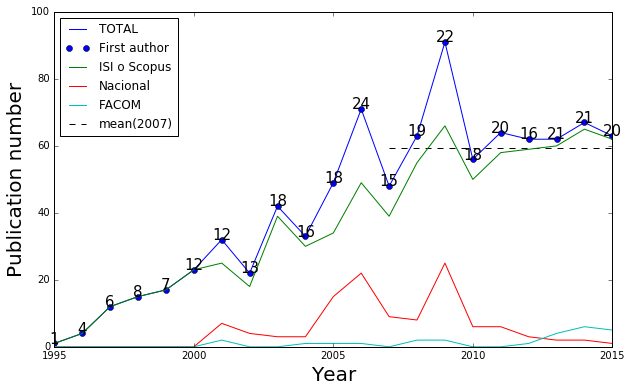

In [22]:
plt.plot(rdf.year,rdf.articles,label='TOTAL')
plt.plot(rdf.year,rdf.articles,'bo',label='First author')
plt.plot(rdf.year,rdf.isi_o_scopus,label='ISI o Scopus')
plt.plot(rdf.year,rdf.nacional,label='Nacional')
plt.plot(rdf.year,rdf.facom,label=u'FACOM')
plt.hlines(rdf[rdf.year>2007].isi_o_scopus.mean(),2007,rdf.year.values[0],linestyles='dashed',label='mean(2007)')
plt.legend(loc='best')
for i in range(len(rdf.year)):
    plt.annotate(str(int(rdf.first_UdeA_author[i])),xy=(rdf.year[i],rdf.articles[i]),\
                 horizontalalignment='center',size=15)
plt.xlabel('Year',size=20)
plt.ylabel('Publication number',size=20)

O en términos del número de autores diferentes de la UdeA que participan en los artículos

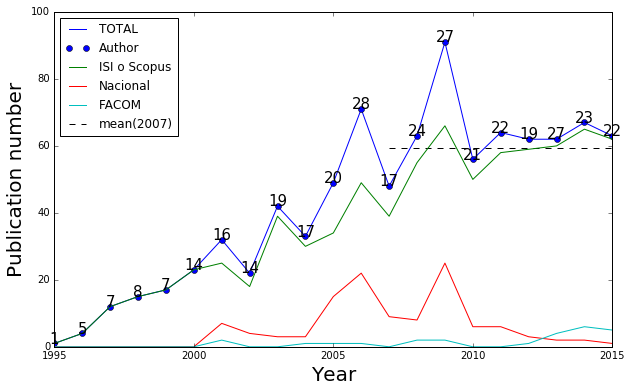

In [23]:
plt.plot(rdf.year,rdf.articles,label='TOTAL')
plt.plot(rdf.year,rdf.articles,'bo',label='Author')
plt.plot(rdf.year,rdf.isi_o_scopus,label='ISI o Scopus')
plt.plot(rdf.year,rdf.nacional,label='Nacional')
plt.plot(rdf.year,rdf.facom,label=u'FACOM')
plt.hlines(rdf[rdf.year>2007].isi_o_scopus.mean(),2007,rdf.year.values[0],linestyles='dashed',label='mean(2007)')
plt.legend(loc='best')
for i in range(len(rdf.year)):
    plt.annotate(str(int(rdf.UdeA_author[i])),xy=(rdf.year[i],rdf.articles[i]),\
                 horizontalalignment='center',size=15)
plt.xlabel('Year',size=20)
plt.ylabel('Publication number',size=20)

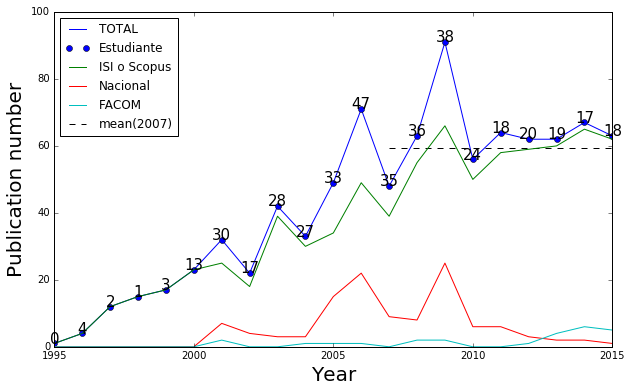

In [24]:
plt.plot(rdf.year,rdf.articles,label='TOTAL')
plt.plot(rdf.year,rdf.articles,'bo',label='Estudiante')
plt.plot(rdf.year,rdf.isi_o_scopus,label='ISI o Scopus')
plt.plot(rdf.year,rdf.nacional,label='Nacional')
plt.plot(rdf.year,rdf.facom,label=u'FACOM')
plt.hlines(rdf[rdf.year>2007].isi_o_scopus.mean(),2007,rdf.year.values[0],linestyles='dashed',label='mean(2007)')
plt.legend(loc='best')
for i in range(len(rdf.year)):
    plt.annotate(str(int(rdf.autor_posgrado[i])),xy=(rdf.year[i],rdf.articles[i]),\
                 horizontalalignment='center',size=15)
plt.xlabel('Year',size=20)
plt.ylabel('Publication number',size=20)

2009 Team

###Conclusión
Se ha alcanzado un valor asintótico

H0 lo separó en H 0 y no lo encontró: solución: admita alguna palabras faltantes en títulos largos:

* http://dx.doi.org/10.1209/0295-5075/109/39002 

### Primeros autores UdeA
Primeros 15

####  Histórico

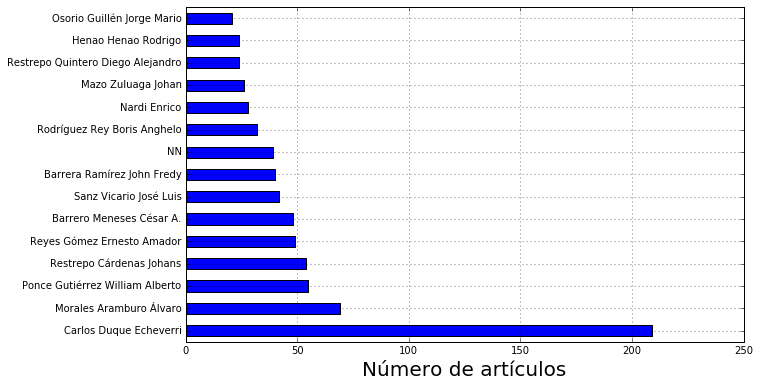

In [25]:
publicadas['First_UdeA_Author'].value_counts()[:15].plot(kind='barh', rot=0, grid=True)
plt.xlabel(u'Número de artículos',size=20)

#### Últimos cinco años

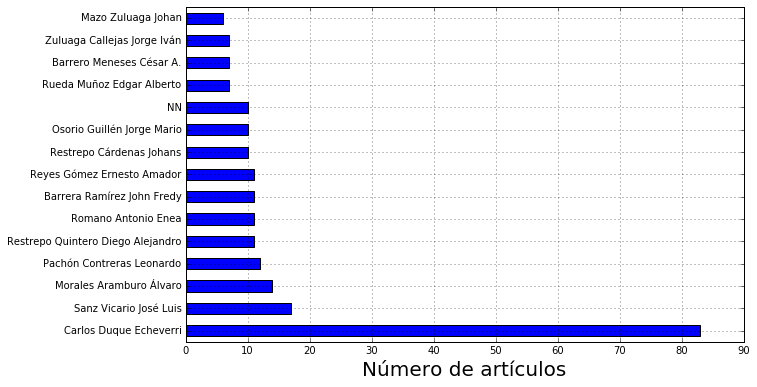

In [26]:
publicadas5['First_UdeA_Author'].value_counts()[:15].plot(kind='barh', rot=0, grid=True)#
plt.xlabel(u'Número de artículos',size=20)

###Conclusión
Se nota el relevo generacional

### Por Grupos de Investigación

Ejemplos plots con `pandas`: http://pandas.pydata.org/pandas-docs/dev/visualization.html

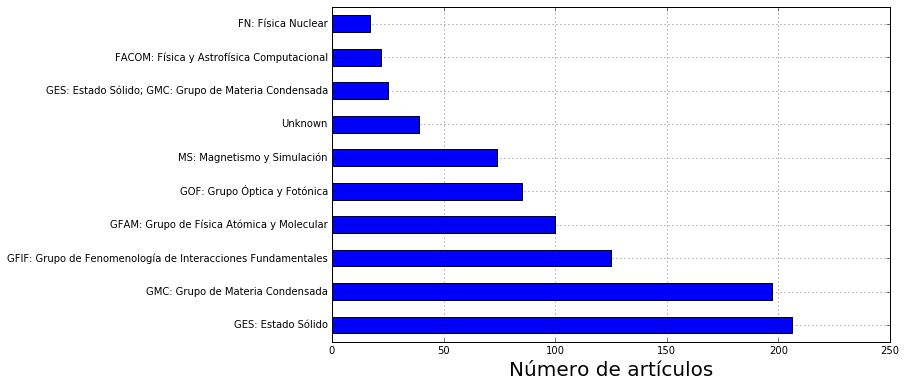

In [27]:
publicadas['Grupo'].value_counts()[:10].plot(kind='barh', rot=0, grid=True)
plt.xlabel(u'Número de artículos',size=20)

### Últimos cinco años

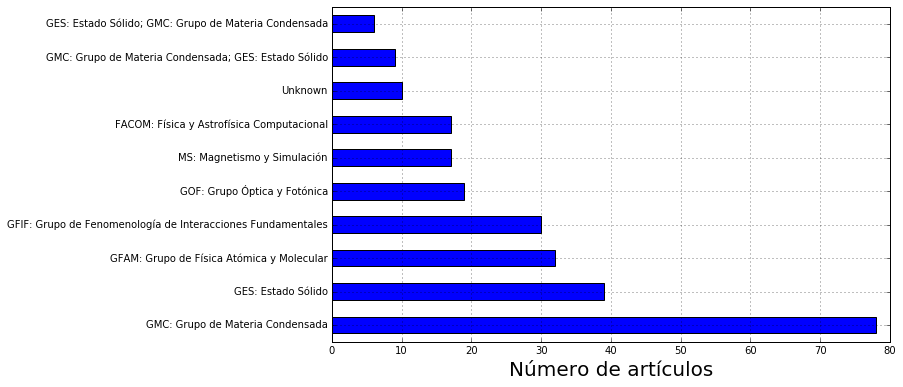

In [28]:
publicadas5['Grupo'].value_counts()[:10].plot(kind='barh', rot=0,grid=True)
plt.xlabel(u'Número de artículos',size=20)

### Internacionales y Nacionales

The group counts, analogous to the value_counts function above, can be computed
    using size. This result is then reshaped into a table with unstack:

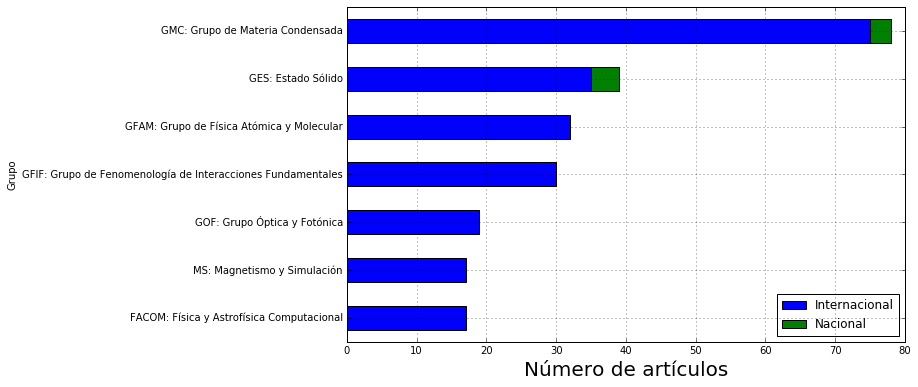

In [29]:
tipo5 = np.where(publicadas5['Tipo'].str.contains('Internacional'),'Internacional', 'Nacional')
by_group_tipo5 = publicadas5.groupby(['Grupo', tipo5])
gt_counts = by_group_tipo5.size().unstack().fillna(0)
indexer = gt_counts.sum(1).argsort()
count_subset = gt_counts.take(indexer)
count_subset[4:].plot(kind='barh', stacked=True,grid=True)
plt.xlabel(u'Número de artículos',size=20)

### Clasificación Colciencias

In [30]:
total=publicadas['Clasificación Colciencias'].value_counts()
print "Total A1+A2: ",total['A1']+total['A2']

Total A1+A2:  692


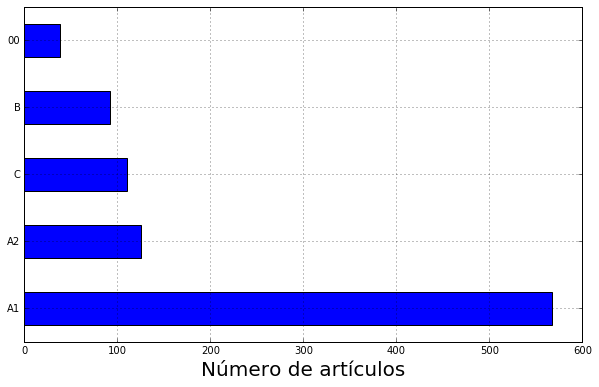

In [31]:
publicadas['Clasificación Colciencias'].value_counts().plot(kind='barh',grid=True)
plt.xlabel(u'Número de artículos',size=20)

#### Últimos cinco  años

In [32]:
total=publicadas5['Clasificación Colciencias'].value_counts()
print "Total A1+A2: ",total['A1']+total['A2']

Total A1+A2:  206


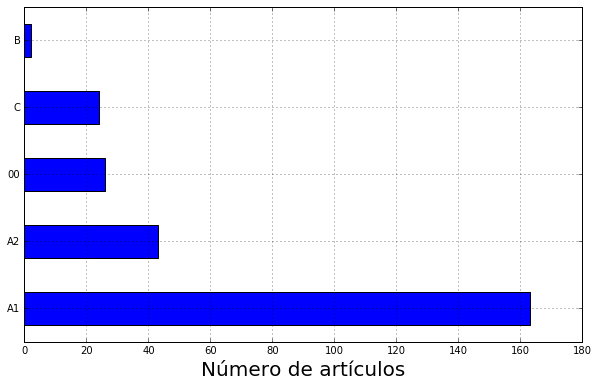

In [33]:
publicadas5['Clasificación Colciencias'].value_counts().plot(kind='barh',grid=True)
plt.xlabel(u'Número de artículos',size=20)

#### Publicadas último año

In [34]:
import datetime
publicadas1=publicadas[publicadas['Año']>datetime.datetime.now().year-1]
len(publicadas1)

4

<h2 id="FI">Factor de impacto</h2>
### Factor de impacto (FI) en revistas con FI>0
Factor de impacto de los últimos 4 años. Para publicaciones muy antigüas se usa el FI más antigüo

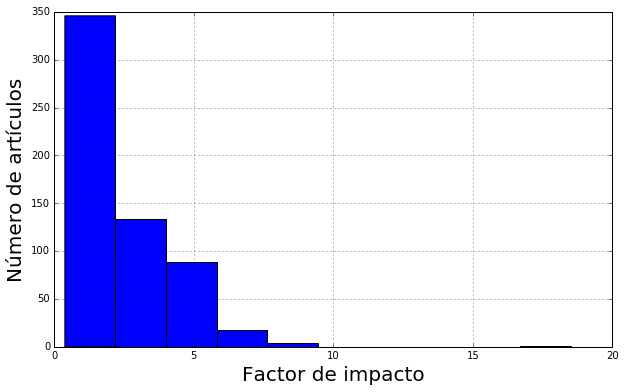

In [35]:
fi=publicadas[['Factor de Impacto']].replace('null',0)
fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
fii.astype('float')['Factor de Impacto'].hist()
plt.ylabel(u'Número de artículos',size=20)
plt.xlabel(u'Factor de impacto',size=20)

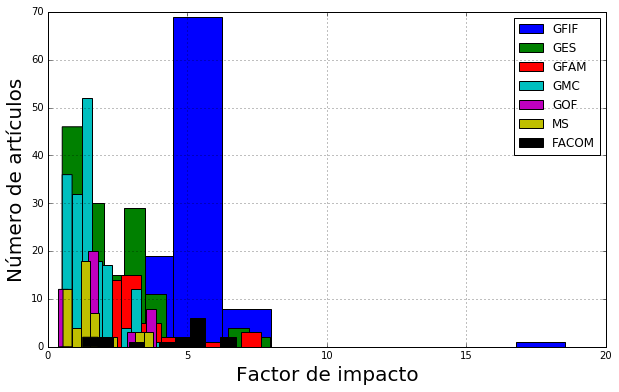

In [36]:
for group in ['GFIF','GES','GFAM','GMC','GOF','MS','FACOM']:
    fi=publicadas[publicadas['Grupo'].str.contains(group)][['Factor de Impacto']].replace('null',0)
    fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
    fii.astype('float')['Factor de Impacto'].hist(label=group) 
    plt.legend(loc='best')
    plt.ylabel(u'Número de artículos',size=20)
    plt.xlabel(u'Factor de impacto',size=20)

### Últimos cinco años

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  if __name__ == '__main__':


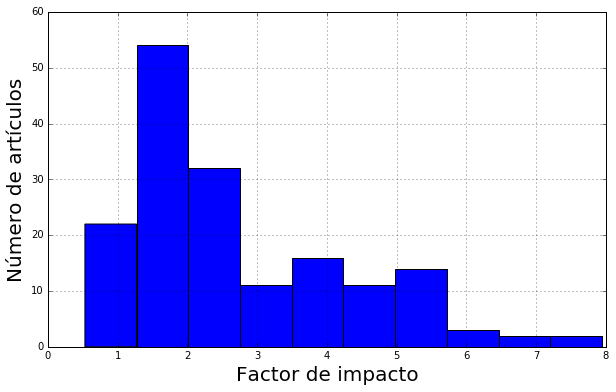

In [37]:
publicadas5['Factor de Impacto']=publicadas5['Factor de Impacto'].replace('Desconocido',-1)
fi=publicadas5[['Factor de Impacto']].replace('null',0)
fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
fii.astype('float')['Factor de Impacto'].hist()
plt.ylabel(u'Número de artículos',size=20)
plt.xlabel(u'Factor de impacto',size=20)

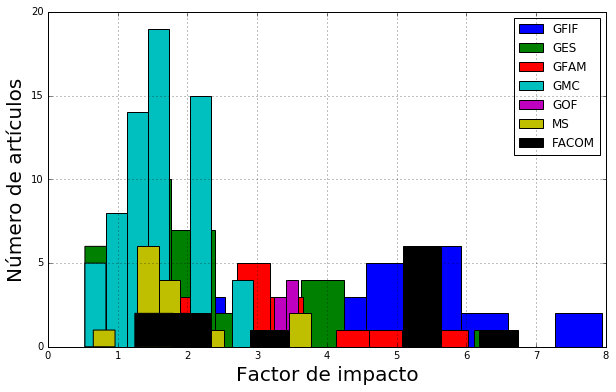

In [38]:
for group in ['GFIF','GES','GFAM','GMC','GOF','MS','FACOM']:
    fi=publicadas5[publicadas5['Grupo'].str.contains(group)][['Factor de Impacto']].replace('null',0)
    fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
    fii.astype('float')['Factor de Impacto'].hist(label=group) 
    plt.legend(loc='best')
    plt.ylabel(u'Número de artículos',size=20)
    plt.xlabel(u'Factor de impacto',size=20)

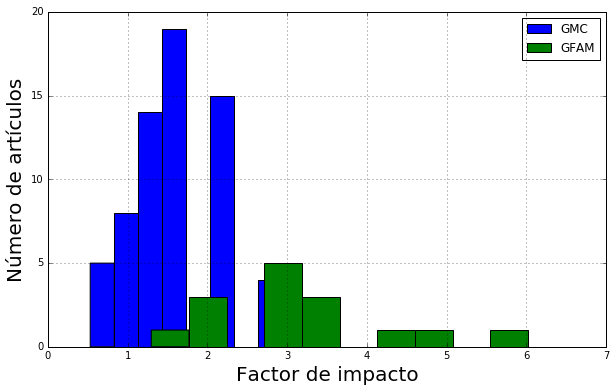

In [39]:
for group in ['GMC','GFAM']:
    fi=publicadas5[publicadas5['Grupo'].str.contains(group)][['Factor de Impacto']].replace('null',0)
    fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
    fii.astype('float')['Factor de Impacto'].hist(label=group) 
    plt.legend(loc='best')
    plt.ylabel(u'Número de artículos',size=20)
    plt.xlabel(u'Factor de impacto',size=20)

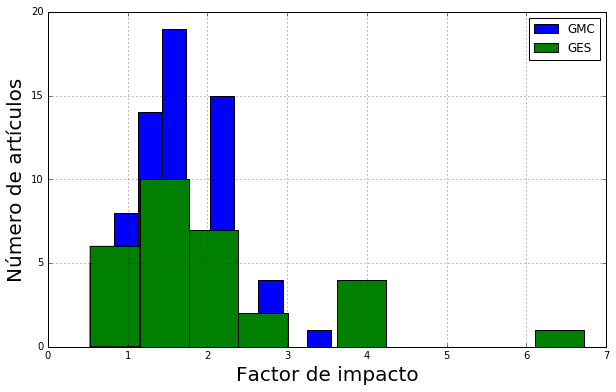

In [40]:
for group in ['GMC','GES']:
    fi=publicadas5[publicadas5['Grupo'].str.contains(group)][['Factor de Impacto']].replace('null',0)
    fii=fi[fi['Factor de Impacto']>0].reset_index(drop=True)
    fii.astype('float')['Factor de Impacto'].hist(label=group) 
    plt.legend(loc='best')
    plt.ylabel(u'Número de artículos',size=20)
    plt.xlabel(u'Factor de impacto',size=20)

In [41]:
#0120-2650 revista colombiana de Fisica
#Physical Review D -> Jose David
#10.1038/nature09084
publicadas[publicadas['Grupo']=='Unknown'].sort('Year').shape

(39, 32)

In [42]:
df[np.logical_and(df.DOI=='Not DOI',df.ISSN=='0000-0000')].shape

(79, 31)

In [43]:
df[np.logical_and(df.DOI=='Not DOI',df.ISSN=='0000-0000')]

,Year,Type,Authors,Publication,Volume,Pages,ISSN,Title,Impreso,PDF,Group,DOI,Type II,Proyect ID,Institution Authors,Colciencias Clasification,Impact Factor,Proyecto,NPages,Año,Tipo,Autor(es),Artículo,Vol.,pág.,Revista,Grupo,Clasificación Colciencias,Factor de Impacto,Cites,Simple
48,2003,Internacional,"Flórez, Juán B; Ponce, William A; Sánchez, Luis A;",PARTICLES AND FIELDS: Tenth Mexican School on Particles and Fields,670,323,0000-0000,Fermion Mass Matrices for a 3‐3‐1 Model,NaN,NaN,GFIF: Grupo de Fenomenología de Interacciones Fundamentales,Not DOI,NaN,NaN,Ponce Gutiérrez William Alberto,00,"-1,0",NaN,6,2003,Internacional,"Flórez, Juán B; Ponce, William A; Sánchez, Luis A;",Fermion Mass Matrices for a 3‐3‐1 Model,670,323,PARTICLES AND FIELDS: Tenth Mexican School on Particles and Fields,GFIF: Grupo de Fenomenología de Interacciones Fundamentales,00,"-1,0",1,fermionmassmatricesfora331model
53,1996,Internacional,"Ponce, William A; Zepeda, Arnulfo;",Yukawa couplings and the origins of mass,2,261,0000-0000,FERMION MASSES IN SOME MODELS WITH HORIZONTAL SYMMETRIES1,NaN,NaN,GFIF: Grupo de Fenomenología de Interacciones Fundamentales,Not DOI,NaN,NaN,Ponce Gutiérrez William Alberto,00,"-1,0",NaN,-1,1996,Internacional,"Ponce, William A; Zepeda, Arnulfo;",FERMION MASSES IN SOME MODELS WITH HORIZONTAL SYMMETRIES1,2,261,Yukawa couplings and the origins of mass,GFIF: Grupo de Fenomenología de Interacciones Fundamentales,00,"-1,0",0,fermionmassesinsomemodelswithhorizontalsymmetries1
83,2002,Internacional,"Henao, Rodrigo; Mejía, Alexandra;",Revista colombiana de física,34,512,0000-0000,ANÁLISIS DE LA CALIDAD DE FRANJAS EN INTEROMETRÍA SPECKLE,NaN,NaN,GOF: Grupo Óptica y Fotónica,Not DOI,NaN,NaN,Henao Henao Rodrigo,00,"-1,0",NaN,-1,2002,Internacional,"Henao, Rodrigo; Mejía, Alexandra;",ANÁLISIS DE LA CALIDAD DE FRANJAS EN INTEROMETRÍA SPECKLE,34,512,Revista colombiana de física,GOF: Grupo Óptica y Fotónica,00,"-1,0",0,anlisisdelacalidaddefranjaseninterometraspeckle
91,1993,Internacional,"Henao, R; F. Medina, F; J. Rabal, H; Trivi, M;",Óptica pura y aplicada,26,583,0000-0000,Correlación de dos patrones de speckles generados por el movimiento tridimensional del difusor.,NaN,NaN,GOF: Grupo Óptica y Fotónica,Not DOI,NaN,NaN,Henao Henao Rodrigo,00,"-1,0",NaN,6,1993,Internacional,"Henao, R; F. Medina, F; J. Rabal, H; Trivi, M;",Correlación de dos patrones de speckles generados por el movimiento tridimensional del difusor.,26,583,Óptica pura y aplicada,GOF: Grupo Óptica y Fotónica,00,"-1,0",0,correlacindedospatronesdespecklesgeneradosporelmovimientotridimensionaldeldifusor
204,1997,Internacional,"Charry, Orlando; Duque, Carlos; Cadena, EL; Jiménez, B; Parra, LF;",Rev. colomb. ortop. traumatol,11,21,0000-0000,Sistema portátil de medición de presión plantar SpMp,NaN,NaN,GMC: Grupo de Materia Condensada,Not DOI,NaN,NaN,Carlos Duque Echeverri,00,"-1,0",NaN,-15,1997,Internacional,"Charry, Orlando; Duque, Carlos; Cadena, EL; Jiménez, B; Parra, LF;",Sistema portátil de medición de presión plantar SpMp,11,21,Rev. colomb. ortop. traumatol,GMC: Grupo de Materia Condensada,00,"-1,0",0,sistemaporttildemedicindepresinplantarspmp
213,2008,Internacional,"Barticevic, Zdenka; Pacheco, Monica; Duque, Carlos A; Oliveira, Luiz E;",APS March Meeting Abstracts,1,1191,0000-0000,Magneto-exciton transitions in laterally coupled quantum dots,NaN,NaN,GMC: Grupo de Materia Condensada,Not DOI,NaN,NaN,Carlos Duque Echeverri,00,"-1,0",NaN,-1,2008,Internacional,"Barticevic, Zdenka; Pacheco, Monica; Duque, Carlos A; Oliveira, Luiz E;",Magneto-exciton transitions in laterally coupled quantum dots,1,1191,APS March Meeting Abstracts,GMC: Grupo de Materia Condensada,00,"-1,0",0,magnetoexcitontransitionsinlaterallycoupledquantumdots
214,2007,Internacional,"Ospina, Walter; Restrepo, Ricardo; Aristizábal, Parménides; Duque, Carlos A;",Scientia et Technica,1,NaN,0000-0000,Efectos de la presión hidrostática sobre la energía de enlace para impurezas donadoras en puntos cuánticos de gaas/ga 